In [1]:
import numpy as np
import cv2
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load preprocessed data for DNN
file_path = '/content/drive/MyDrive/NLP_Workspace/Data/DNN_Binary_Labeled/'

df_data = pd.read_csv(file_path + "F_vs_T_data.csv")

In [3]:
df_data.head(10)
df_data.isnull().any()
df_data = df_data.dropna(how='any',axis=0)

In [4]:
df_data.describe()

,label,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
count,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,...,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000,198642.000000
mean,0.499839,0.560314,0.361566,0.092869,1.250546,-0.868388,0.231778,0.807898,-0.785229,0.887393,...,-0.640821,0.682973,-0.934219,0.030949,-0.645088,-0.402813,0.355011,-0.582733,0.227410,0.010737
std,0.500001,0.645151,0.549036,0.525966,0.831370,0.707000,0.596241,0.726631,0.662248,0.691522,...,0.698269,0.654709,0.710346,0.563568,0.668436,0.620389,0.656576,0.598409,0.572102,0.553574
min,0.000000,-6.305176,-2.542236,-5.718872,-3.269958,-4.513428,-4.694336,-6.679688,-5.651855,-4.519287,...,-5.538086,-4.955078,-5.978973,-5.292908,-5.431641,-7.779053,-4.625732,-6.010742,-4.319458,-3.177124
25%,0.000000,0.096420,0.000000,-0.205322,0.592529,-1.355530,-0.117058,0.245632,-1.199562,0.337402,...,-1.092712,0.203674,-1.410889,-0.284790,-1.083984,-0.762695,-0.056183,-0.949890,-0.127441,-0.314087
50%,0.000000,0.490601,0.292419,0.075287,1.204382,-0.813049,0.188110,0.737976,-0.708298,0.840485,...,-0.553322,0.614014,-0.864639,0.029785,-0.580490,-0.341309,0.288025,-0.516479,0.175903,0.000000
75%,1.000000,0.974289,0.692070,0.386292,1.817261,-0.311646,0.582733,1.307358,-0.284668,1.363037,...,-0.118652,1.105188,-0.380573,0.351074,-0.161388,-0.002051,0.756836,-0.160156,0.568726,0.318382
max,1.000000,4.739014,4.809937,8.631409,8.592773,2.346924,5.228271,4.490234,2.821167,5.316772,...,3.493164,6.076660,2.633789,5.368652,4.992218,3.496752,5.003540,7.576965,10.454346,5.238281


In [5]:
fetched_data = df_data.to_numpy()
len(fetched_data), len(fetched_data[0])

(198642, 301)

In [6]:
LENGTH_DATA = len(fetched_data)

import random
train_example_nums = int(0.85 * LENGTH_DATA)
test_example_nums = int(0.15 * LENGTH_DATA)

random_ids = [i for i in range(LENGTH_DATA)]
random.Random(4).shuffle(random_ids)

random_train_ids = random_ids[:train_example_nums]
random_test_ids = random_ids[train_example_nums:]

len(random_train_ids), len(random_test_ids)

(168845, 29797)

In [7]:
X_train = torch.as_tensor(fetched_data[random_train_ids, 1:])
Y_train = torch.as_tensor(fetched_data[random_train_ids, 0]).type(torch.int64)

X_test = torch.as_tensor(fetched_data[random_test_ids, 1:])
Y_test = torch.as_tensor(fetched_data[random_test_ids, 0]).type(torch.int64)

In [8]:
print(X_train, X_train.shape)

tensor([[ 0.6639, -0.7583, -1.7969,  ...,  0.6383,  2.7354,  1.1365],
        [ 0.8391,  0.6574,  0.8860,  ..., -0.9298,  0.2361,  0.8857],
        [ 0.7056, -0.1355,  1.2393,  ..., -1.6752, -0.1505, -0.8146],
        ...,
        [ 1.1547,  0.7468,  0.1050,  ..., -0.0637, -0.1396,  0.6223],
        [ 1.0549,  0.1429,  0.6171,  ..., -0.0109, -0.0771,  1.0657],
        [ 0.1079, -0.0356, -0.1902,  ..., -0.0928,  0.2080, -0.0559]],
       dtype=torch.float64) torch.Size([168845, 300])


In [9]:
print(Y_train, Y_train.shape)

tensor([1, 1, 0,  ..., 0, 0, 1]) torch.Size([168845])


In [10]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y):
    self.labels = Y
    self.posts = X

  def __len__(self):
    return len(self.posts)

  def __getitem__(self, index):
    post = self.posts[index]
    label = self.labels[index]
    return post, label

In [11]:
train_dataset = Dataset(X_train, Y_train)
test_dataset = Dataset(X_test, Y_test)

print(min(Y_train), max(Y_train))
print(Y_test)

tensor(0) tensor(1)
tensor([0, 1, 1,  ..., 0, 0, 0])


In [12]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [14]:
device = get_default_device()
device

device(type='cpu')

In [15]:
class ClassificationBase(nn.Module):
    def training_step(self, batch):
        posts, labels = batch 
        out = self(posts.type(torch.FloatTensor).to(device))                  # Generate predictions
        loss = F.cross_entropy(out, labels.to(device)) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        posts, labels = batch
        out = self(posts.type(torch.FloatTensor).to(device))                    # Generate predictions
        loss = F.cross_entropy(out, labels.to(device))   # Calculate loss
        acc = accuracy(out, labels.to(device))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr, momentum = 0.9)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [18]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [19]:
class DNN(ClassificationBase):
  def __init__(self) -> None:
    super().__init__()
    self.fc1 = torch.nn.Linear(300, 256)
    self.fc2 = torch.nn.Linear(256, 128)
    self.fc3 = torch.nn.Linear(128, 128)
    self.fc4 = torch.nn.Linear(128, 2)


  def forward(self, x: torch.Tensor) -> torch.Tensor:     
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    return x

In [20]:
model = DNN()
model.to(device)

DNN(
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=2, bias=True)
)

In [21]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, num_workers=1, shuffle = True, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size*4, num_workers=1, pin_memory=True)

In [22]:
history = [evaluate(model, test_dataloader)]
history

[{'val_loss': 0.6942768692970276, 'val_acc': 0.5033606290817261}]

In [23]:
history += fit(20, 0.0001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 0.6920, val_acc: 0.5273
Epoch [1], val_loss: 0.6906, val_acc: 0.5416
Epoch [2], val_loss: 0.6885, val_acc: 0.5475
Epoch [3], val_loss: 0.6855, val_acc: 0.5543
Epoch [4], val_loss: 0.6821, val_acc: 0.5604
Epoch [5], val_loss: 0.6794, val_acc: 0.5654
Epoch [6], val_loss: 0.6777, val_acc: 0.5708
Epoch [7], val_loss: 0.6765, val_acc: 0.5726
Epoch [8], val_loss: 0.6753, val_acc: 0.5750
Epoch [9], val_loss: 0.6744, val_acc: 0.5781
Epoch [10], val_loss: 0.6737, val_acc: 0.5795
Epoch [11], val_loss: 0.6732, val_acc: 0.5794
Epoch [12], val_loss: 0.6730, val_acc: 0.5817
Epoch [13], val_loss: 0.6722, val_acc: 0.5817
Epoch [14], val_loss: 0.6721, val_acc: 0.5837
Epoch [15], val_loss: 0.6715, val_acc: 0.5838
Epoch [16], val_loss: 0.6711, val_acc: 0.5839
Epoch [17], val_loss: 0.6712, val_acc: 0.5852
Epoch [18], val_loss: 0.6705, val_acc: 0.5855
Epoch [19], val_loss: 0.6709, val_acc: 0.5855


In [25]:
history += fit(10, 0.00001 , model, train_dataloader, test_dataloader)

Epoch [0], val_loss: 0.6702, val_acc: 0.5860
Epoch [1], val_loss: 0.6703, val_acc: 0.5857
Epoch [2], val_loss: 0.6702, val_acc: 0.5861
Epoch [3], val_loss: 0.6702, val_acc: 0.5855
Epoch [4], val_loss: 0.6701, val_acc: 0.5860
Epoch [5], val_loss: 0.6703, val_acc: 0.5858
Epoch [6], val_loss: 0.6702, val_acc: 0.5857
Epoch [7], val_loss: 0.6701, val_acc: 0.5856
Epoch [8], val_loss: 0.6700, val_acc: 0.5858
Epoch [9], val_loss: 0.6700, val_acc: 0.5864


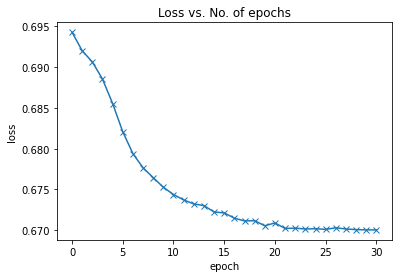

In [26]:
plot_losses(history)

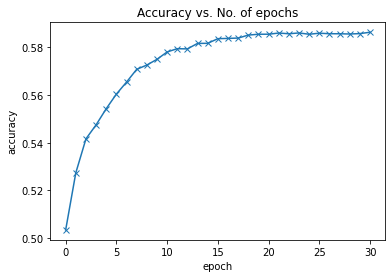

In [27]:
plot_accuracies(history)

In [28]:
evaluate(model, test_dataloader)

{'val_loss': 0.6700414419174194, 'val_acc': 0.5863790512084961}

In [29]:
torch.save(model.state_dict(), 'emotion_classification-feedforward.pth')